In [1]:
import numpy as np
import pandas as pd

import collections

import re, nltk

from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
pd.set_option("display.max_colwidth", 500)

In [4]:
np.random.seed(42)
random_state = 42

In [5]:
train_data_df  = pd.read_table('data/UMICH_SI650_train_data.txt', names=['sentiment', 'comment'], header=None, delimiter="\t", quoting=3)
test_data_df  = pd.read_table('data/UMICH_SI650_test_data.txt', names=['comment'], header=None, delimiter="\t", quoting=3)

In [6]:
train_data_df.head(5)

,sentiment,comment
0,1,The Da Vinci Code book is just awesome.
1,1,"this was the first clive cussler i've ever read, but even books like Relic, and Da Vinci code were more plausible than this."
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly didn't seem to hold it's own.


In [7]:
test_data_df.head(5)

,comment
0,""" I don't care what anyone says, I like Hillary Clinton."
1,have an awesome time at purdue!..
2,"Yep, I'm still in London, which is pretty awesome: P Remind me to post the million and one pictures that I took when I get back to Markham!..."
3,"Have to say, I hate Paris Hilton's behavior but I do think she's kinda cute.."
4,i will love the lakers.


In [8]:
# Inspect how many are positive sentiment and how many are negative
train_data_df.sentiment.value_counts()

1    3995
0    3091
Name: sentiment, dtype: int64

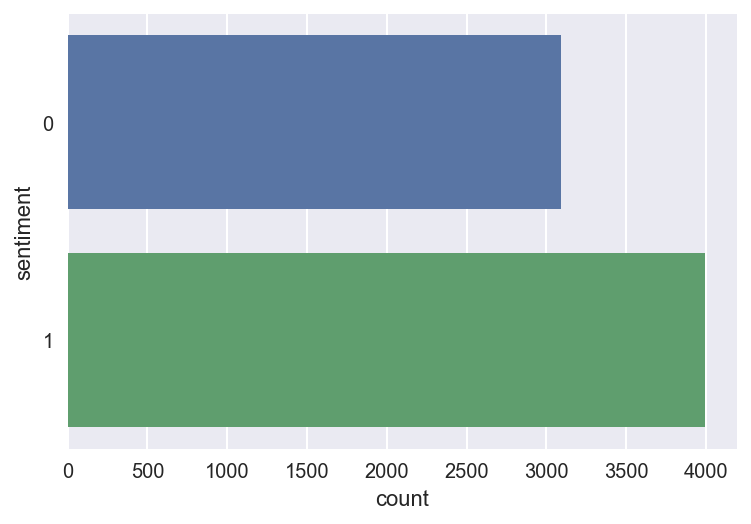

In [9]:
sns.countplot(y='sentiment', data=train_data_df);

In [10]:
INPUT_FILE = "../data/umich-sentiment-train.txt"
VOCAB_SIZE = 5000
EMBED_SIZE = 100
NUM_FILTERS = 256
NUM_WORDS = 3
BATCH_SIZE = 64
NUM_EPOCHS = 20

In [11]:
counter = collections.Counter()
with open(file='data/UMICH_SI650_train_data.txt', mode='r', encoding='utf-8') as fin:
    maxlen = 0
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        stop_words = set(nltk.corpus.stopwords.words('english'))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token in stop_words]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            counter[word] += 1

In [12]:
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_size = len(word2index) + 1
index2word = {k:v for k, v in word2index.items()}

We pad each of our sentences to predetermined length maxlen (in this case the number of words in the longest sentence in the training set). We also convert our labels to categorical format using a Keras utility function. The last two steps are a standard workflow for handling text input that we will see again and again:

In [13]:
xs, ys = [], []
with open(file='data/UMICH_SI650_train_data.txt', mode='r', encoding='utf-8') as fin:
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        stop_words = set(nltk.corpus.stopwords.words('english'))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token in stop_words]
        wids = [word2index[word] for word in words]
        xs.append(wids)

In [14]:
X = pad_sequences(xs, maxlen=maxlen)
y = np_utils.to_categorical(ys)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [16]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation='softmax'))

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_test, y_test), 
                    shuffle=True)

Train on 4960 samples, validate on 2126 samples
Epoch 1/20
4960/4960 [==============================] - 3s - loss: 0.2671 - acc: 0.9016 - val_loss: 0.0336 - val_acc: 0.9878
Epoch 2/20
4960/4960 [==============================] - 0s - loss: 0.0139 - acc: 0.9966 - val_loss: 0.0175 - val_acc: 0.9929
Epoch 3/20
4960/4960 [==============================] - 0s - loss: 0.0041 - acc: 0.9996 - val_loss: 0.0152 - val_acc: 0.9934
Epoch 4/20
4960/4960 [==============================] - 0s - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0150 - val_acc: 0.9944
Epoch 5/20
4960/4960 [==============================] - 0s - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0137 - val_acc: 0.9929
Epoch 6/20
4960/4960 [==============================] - 0s - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0134 - val_acc: 0.9939
Epoch 7/20
4960/4960 [==============================] - 0s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0138 - val_acc: 0.9948
Epoch 8/20
4960/4960 [==============================] - 0s - loss: 0.0014 - a

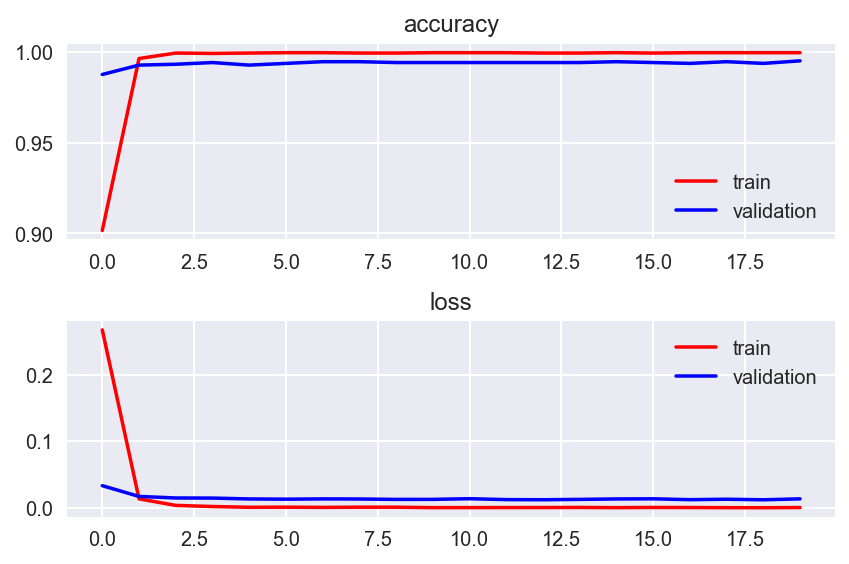

In [19]:
# plot loss function
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
#plt.show()

In [20]:
# evaluate model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Test score: 0.014, accuracy: 0.995


## Fine-tuning learned embeddings from word2vec

In this example, we will use the same network as the one we used to learn our embeddings from scratch. In terms of code, the only major difference is an extra block of code to load the word2vec model and build up the weight matrix for the embedding layer.

As always, we start with the imports and set up a random seed for repeatability. In addition to the imports we have seen previously, there is an additional one to import the word2vec model from gensim:

In [33]:
import numpy as np
import pandas as pd

import collections

import re, nltk

from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

In [34]:
INPUT_FILE = "data/UMICH_SI650_train_data.txt"
WORD2VEC_MODEL = "data/GoogleNews-vectors-negative300.bin.gz"
VOCAB_SIZE = 5000
EMBED_SIZE = 300
NUM_FILTERS = 256
NUM_WORDS = 3
BATCH_SIZE = 64
NUM_EPOCHS = 10

In [35]:
counter = collections.Counter()
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    maxlen = 0
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        stop_words = set(nltk.corpus.stopwords.words('english'))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token in stop_words]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            counter[word] += 1

In [36]:
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_size = len(word2index) + 1
index2word = {k:v for k, v in word2index.items()}

In [37]:
xs, ys = [], []
with open(file='data/UMICH_SI650_train_data.txt', mode='r', encoding='utf-8') as fin:
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        stop_words = set(nltk.corpus.stopwords.words('english'))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token in stop_words]
        wids = [word2index[word] for word in words]
        xs.append(wids)

In [38]:
X = pad_sequences(xs, maxlen=maxlen)
y = np_utils.to_categorical(ys)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [42]:
# load word2vec model
word2vec = KeyedVectors.load_word2vec_format(WORD2VEC_MODEL, binary=True)
embedding_weights = np.zeros((vocab_size, EMBED_SIZE))
for word, index in word2index.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [43]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=EMBED_SIZE, 
                    input_length=maxlen, 
                    weights=[embedding_weights],
                    trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation='softmax'))

In [44]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_test, y_test), 
                    shuffle=True)

Train on 4960 samples, validate on 2126 samples
Epoch 1/10
4960/4960 [==============================] - 1s - loss: 0.1027 - acc: 0.9645 - val_loss: 0.0175 - val_acc: 0.9944
Epoch 2/10
4960/4960 [==============================] - 1s - loss: 0.0061 - acc: 0.9988 - val_loss: 0.0126 - val_acc: 0.9962
Epoch 3/10
4960/4960 [==============================] - 1s - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0131 - val_acc: 0.9962
Epoch 4/10
4960/4960 [==============================] - 1s - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0131 - val_acc: 0.9967
Epoch 5/10
4960/4960 [==============================] - 1s - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0111 - val_acc: 0.9962
Epoch 6/10
4960/4960 [==============================] - 1s - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0125 - val_acc: 0.9962
Epoch 7/10
4960/4960 [==============================] - 1s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0131 - val_acc: 0.9962
Epoch 8/10
4960/4960 [==============================] - 1s - loss: 0.0029 - a

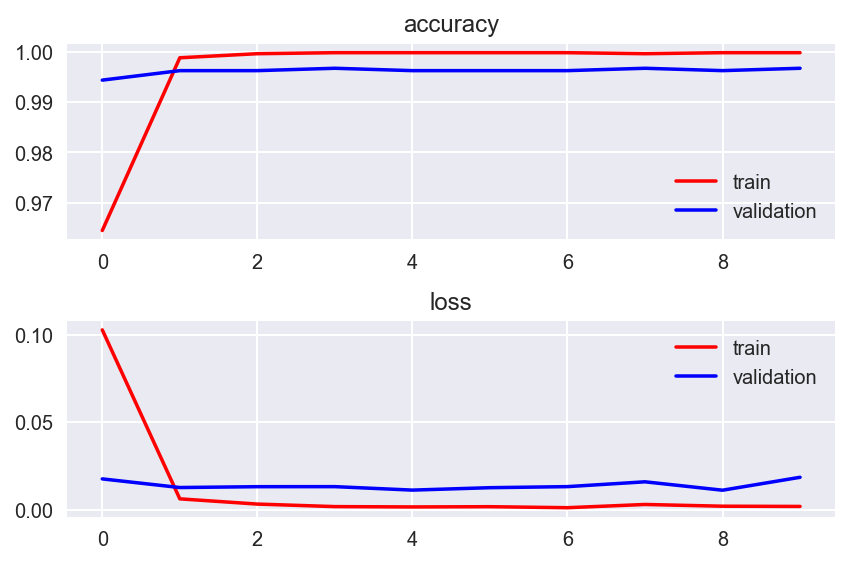

In [46]:
# plot loss function
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
#plt.show()

In [47]:
# evaluate model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Test score: 0.018, accuracy: 0.997


## Fine-tuning learned embeddings from GloVe

In this example, we will use the same network as the one we used to learn our embeddings from scratch. In terms of code, the only major difference is an extra block of code to load the word2vec model and build up the weight matrix for the embedding layer.

As always, we start with the imports and set up a random seed for repeatability. In addition to the imports we have seen previously, there is an additional one to import the word2vec model from gensim:

In [66]:
import numpy as np
import pandas as pd

import collections

import re, nltk

import keras
from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

In [67]:
INPUT_FILE = "data/UMICH_SI650_train_data.txt"
GLOVE_MODEL = "data/glove.6B/glove.6B.300d.txt"
VOCAB_SIZE = 5000
EMBED_SIZE = 300
NUM_FILTERS = 256
NUM_WORDS = 3
BATCH_SIZE = 64
NUM_EPOCHS = 10

In [68]:
counter = collections.Counter()
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    maxlen = 0
    for line in fin:
        label, sentence = line.strip().split('\t')
        #sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        #stop_words = set(nltk.corpus.stopwords.words('english'))
        #words = [token.lower() for token in nltk.word_tokenize(sentence) if not token in stop_words]
        words = [token.lower() for token in nltk.word_tokenize(sentence)]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            counter[word] += 1

In [69]:
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_size = len(word2index) + 1
index2word = {k:v for k, v in word2index.items()}

In [70]:
xs, ys = [], []
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    for line in fin:
        label, sentence = line.strip().split('\t')
        #sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        #stop_words = set(nltk.corpus.stopwords.words('english'))
        #words = [token.lower() for token in nltk.word_tokenize(sentence) if not token in stop_words]
        words = [token.lower() for token in nltk.word_tokenize(sentence)]
        wids = [word2index[word] for word in words]
        xs.append(wids)

In [71]:
X = keras.preprocessing.sequence.pad_sequences(xs, maxlen=maxlen)
y = keras.utils.np_utils.to_categorical(ys)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [73]:
# load GloVe vectors
word2emb = {}
with open(GLOVE_MODEL, "rb") as fglove:
    for line in fglove:
        cols = line.strip().split()
        word = cols[0]
        embedding = np.array(cols[1:], dtype="float32")
        word2emb[word] = embedding

In [74]:
embedding_weights = np.zeros((vocab_size, EMBED_SIZE))
for word, index in word2index.items():
    try:
        embedding_weights[index, :] = word2emb[word]
    except KeyError:
        pass

In [75]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=EMBED_SIZE, 
                    input_length=maxlen, 
                    weights=[embedding_weights],
                    trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation='softmax'))

In [76]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_test, y_test), 
                    shuffle=True)

Train on 4960 samples, validate on 2126 samples
Epoch 1/10
4960/4960 [==============================] - 3s - loss: 0.6905 - acc: 0.5587 - val_loss: 0.6873 - val_acc: 0.5701
Epoch 2/10
4960/4960 [==============================] - 1s - loss: 0.6873 - acc: 0.5611 - val_loss: 0.6851 - val_acc: 0.5701
Epoch 3/10
4960/4960 [==============================] - 1s - loss: 0.6862 - acc: 0.5611 - val_loss: 0.6841 - val_acc: 0.5701
Epoch 4/10
4960/4960 [==============================] - 1s - loss: 0.6859 - acc: 0.5611 - val_loss: 0.6838 - val_acc: 0.5701
Epoch 5/10
4960/4960 [==============================] - 1s - loss: 0.6858 - acc: 0.5611 - val_loss: 0.6836 - val_acc: 0.5701
Epoch 6/10
4960/4960 [==============================] - 1s - loss: 0.6857 - acc: 0.5611 - val_loss: 0.6836 - val_acc: 0.5701
Epoch 7/10
4960/4960 [==============================] - 1s - loss: 0.6857 - acc: 0.5611 - val_loss: 0.6835 - val_acc: 0.5701
Epoch 8/10
4960/4960 [==============================] - 1s - loss: 0.6857 - a

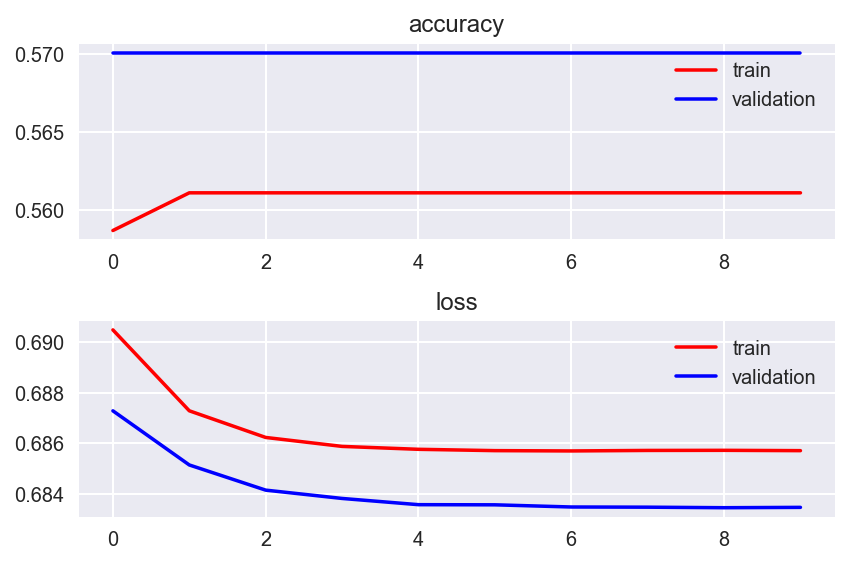

In [78]:
# plot loss function
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
#plt.show()

In [79]:
# evaluate model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Test score: 0.683, accuracy: 0.570
